In [1]:
import matplotlib.cm as cm
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from tqdm import tqdm
from epicare.envs import EpiCare
from epicare.policies import StandardOfCare, ClinicalTrial, Oracle, Random
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FixedLocator

from tueplots import bundles

plt.rcParams.update(bundles.icml2024())
plt.rcParams["figure.dpi"] = 300

results_direrctory = "../algorithms/results/"

/home/masonhargrave/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-22 18:15:36.901063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 18:15:36.901202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 18:15:36.925831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 18:15:36.986720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary 

In [2]:
def run_episode(
    env, policy, policy_name, policy_stats=None, collect_series=False, verbose=False
):
    observation = env.reset()
    total_reward = 0
    done = False
    steps = 0
    transitions = 0
    time_to_remission = (
        None  # Initialize as None, which will be updated if remission occurs
    )

    # For series collection
    observations_collected = [observation]
    states_collected = [env.current_disease]

    # Reset the policy at the start of each episode if it has a reset method
    if hasattr(policy, "reset"):
        policy.reset()

    while not done:
        # Obtain the treatment decision from the policy
        if isinstance(policy, (StandardOfCare, ClinicalTrial, Random)):
            treatment = policy.get_treatment(
                current_disease=env.current_disease, current_step=steps
            )
        else:
            treatment = policy.step(observation)

        if treatment is None:
            if verbose:
                print(f"Remission or no treatment at step {step}, ending episode.")
            break

        # Perform the action in the environment
        old_state = env.current_disease
        observation, reward, done, info = env.step(treatment)
        # If observations has an element with a negative value
        if observation.min() < 0:
            raise ValueError(f"Observation has negative values: {observation}")
        new_state = env.current_disease
        total_reward += reward
        if verbose:
            print(f"Step {step + 1}: Applied Treatment {treatment}, Reward {reward}")

        if collect_series:
            # Collect the series
            observations_collected.append(observation)
            states_collected.append(env.current_disease)

        # If the policy has an update method, call it with the treatment and reward
        if hasattr(policy, "update"):
            policy.update(treatment, reward)

        # Check if remission was achieved and record the time step
        if info.get("remission", False):
            time_to_remission = steps + 1  # Plus one because steps start from 0
            if verbose:
                print(f"Remission achieved at step {time_to_remission}")
            break  # Optional: break if you want to stop the episode at remission

        steps += 1
        if old_state != new_state:
            transitions += 1

    # Update policy_stats only if it is provided
    if policy_stats is not None:
        if policy_name not in policy_stats:
            policy_stats[policy_name] = {
                "total_rewards": [],
                "remission": [],
                "times_to_remission": [],
            }

        policy_stats[policy_name]["total_rewards"].append(total_reward)
        if time_to_remission is not None:
            policy_stats[policy_name]["times_to_remission"].append(time_to_remission)
        policy_stats[policy_name]["remission"].append(
            1 if time_to_remission is not None else 0
        )

    if collect_series:
        return observations_collected, states_collected
    else:
        return total_reward, time_to_remission, steps, transitions

/home/masonhargrave/anaconda3/envs/EpiCare/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/tmp/ipykernel_5951/2017549127.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


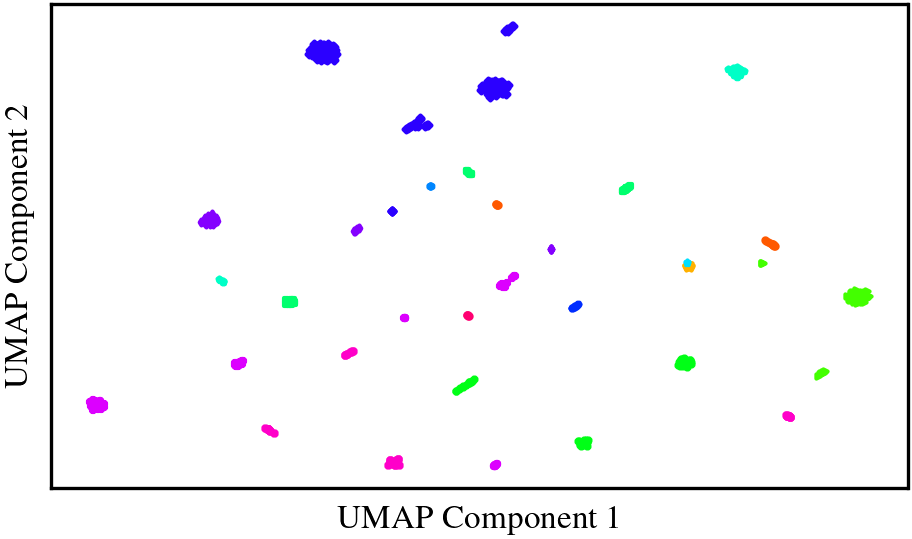

In [3]:
# Create an instance of the environment with specified parameters
env = EpiCare(
    n_symptoms=8,
    n_diseases=16,
    n_treatments=16,
    seed=1,
    symptom_modulation_range=(-0.01, 0),
    symptom_std_range=(0.01, 0.0),
)

unique_states = np.arange(env.n_diseases)

# Initialize the Random policy
policy = Random(env)

# Collect observations from the environment during simulation
observations = []
states = []


# Number of episodes for the simulation
num_episodes = 100

for _ in range(num_episodes):
    obs_collected, states_collected = run_episode(
        env, policy, "Random", collect_series=True
    )
    for state, obs in zip(states_collected, obs_collected):
        if "Remission" not in state:  # Ignore remission states
            observations.append(obs)
            # Extract the integer index of the disease state
            state_index = int(state.split("_")[1])  # Assuming the format is 'Disease_X'
            states.append(state_index)

# Convert to numpy arrays and proceed with preprocessing and UMAP
observations = np.array(observations)
states = np.array(states)

# Preprocess the data
observations = StandardScaler().fit_transform(observations)

# Perform UMAP
umap_reducer = umap.UMAP(
    n_components=2, n_neighbors=3, min_dist=0.25, metric="canberra"
)
observations_reduced = umap_reducer.fit_transform(observations)

# Generate a color palette with seaborn
palette = sns.color_palette(
    "hsv", len(unique_states)
)  # "hsv" is a circular color space

# Generate a list of markers
markers = ["o", "v", "^", "<", ">", "8", "s", "p", "*", "h", "H", "D", "d", "P", "X"]

# Plotting the clusters
for i, (color, marker) in enumerate(
    zip(palette, markers * (len(unique_states) // len(markers) + 1))
):
    state_mask = states == unique_states[i]
    plt.scatter(
        observations_reduced[state_mask, 0],
        observations_reduced[state_mask, 1],
        color=color,
        marker=marker,
        label=f"State {unique_states[i]}",
        s=1,
    )

plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
# Remove x and y ticks
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("umap.pdf")

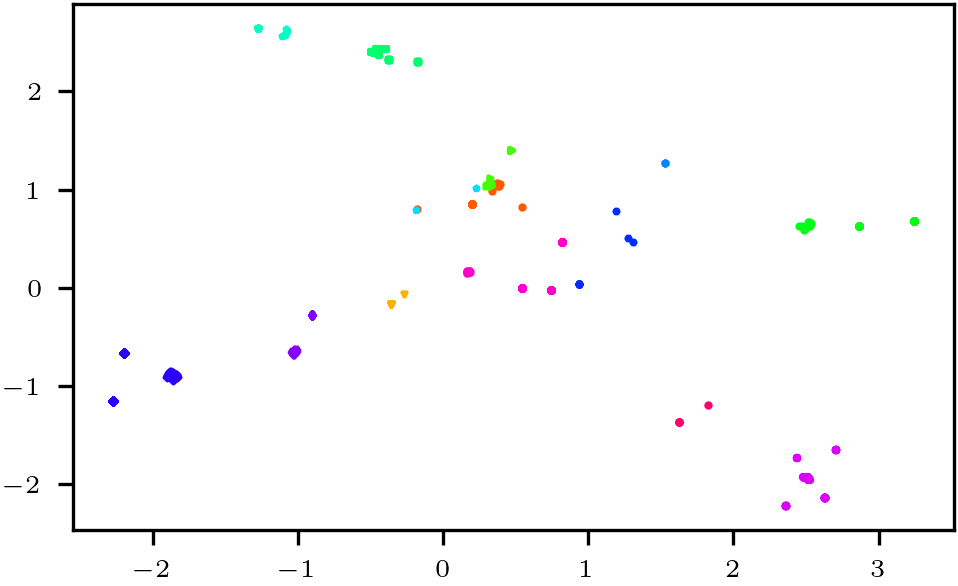

In [4]:
# PCA plot
from sklearn.decomposition import PCA

pca_reducer = PCA(n_components=2)
observations_pca = pca_reducer.fit_transform(observations)

# Plotting the clusters
for i, (color, marker) in enumerate(
    zip(palette, markers * (len(unique_states) // len(markers) + 1))
):
    state_mask = states == unique_states[i]
    plt.scatter(
        observations_pca[state_mask, 0],
        observations_pca[state_mask, 1],
        color=color,
        marker=marker,
        label=f"State {unique_states[i]}",
        s=1,
    )

FileNotFoundError: [Errno 2] No such file or directory: '../algorithms/results/iql_restriction.csv'

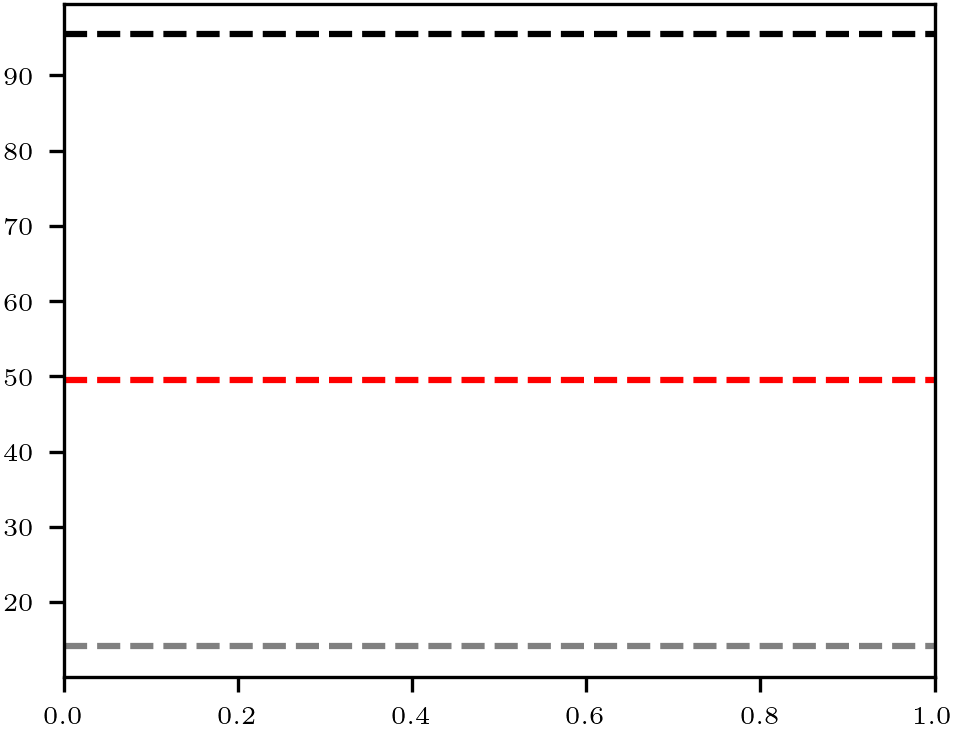

In [3]:
plt.figure(figsize=(3.25, 2.5))  # Adjust the figure size as needed for a half-page plot

models = ["iql", "cql", "td3_bc"]  # List of models to plot
labels = ["IQL", "CQL", "TD3+BC"]  # List of labels for the legend

# Adding a horizontal line for typical SoC performance
plt.axhline(y=95.5, color="k", linestyle="--", label="OP")
plt.axhline(y=49.5, color="r", linestyle="--", label="SoC")
plt.axhline(y=14.1, color="gray", linestyle="--", label="Random")

for model in models:
    df = pd.read_csv(os.path.join(results_direrctory, model + "_restriction.csv"))
    grouped = df.groupby(["episodes_avail"])
    mean = grouped["mean_return"].mean()
    std = grouped["mean_return"].std()

    # Plotting mean
    plt.plot(
        mean.index, mean, marker="o", label=labels[models.index(model)], markersize=4
    )

    # Adding shaded error (std deviation)
    plt.fill_between(mean.index, mean - std, mean + std, alpha=0.2)

# Setting a logarithmic scale for the x-axis
plt.xscale("log")

# Labels and title
plt.xlabel("Episodes Available")
plt.ylabel("Mean Episode Reward")

# Making the legend readable and not overlap with the plot
plt.legend(title="Model/Policy", loc="lower right")

# Fine-tuning the appearance
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area

# Saving the figure
plt.savefig("data_restriction.pdf")

# Display the plot
plt.show()

100%|██████████| 100/100 [02:17<00:00,  1.37s/it]
/tmp/ipykernel_5951/1525949468.py:106: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


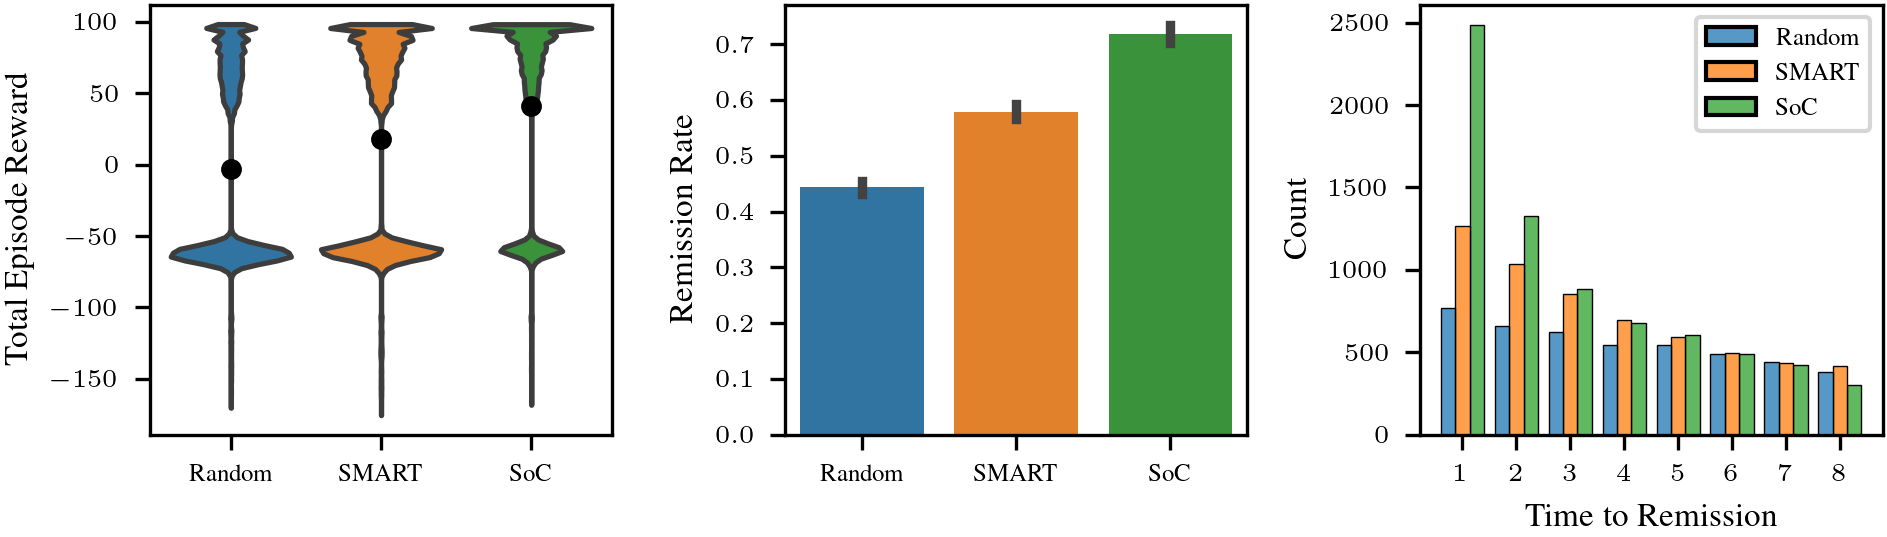

Number of transitions per episode:  0.8430333333333333


In [5]:
# Assuming `environment` and policy evaluation methods are defined elsewhere in your code

num_seeds = 100  # Number of random seeds

# Initialize containers for aggregated data
all_rewards = []
all_remission_rates = []
all_times_to_remission = []
num_steps = 0
num_transitions = 0
num_episodes = 100

for seed in tqdm(range(num_seeds)):
    environment = EpiCare(seed=seed)

    # Setting up the policies
    policies = {
        "Random": Random(environment),
        "SMART": ClinicalTrial(environment),
        "SoC": StandardOfCare(environment, alpha=0.8),
        #'OP': Oracle(environment),
    }

    # This dictionary will store the stats for each policy
    policy_stats = {
        name: {"total_rewards": [], "remission": [], "times_to_remission": []}
        for name in policies
    }

    # Simulation loop
    for name, policy in policies.items():
        for episode in range(num_episodes):
            total_reward, time_to_remission, steps, transitions = run_episode(
                environment, policy, name, policy_stats, verbose=False
            )
            num_steps += steps
            num_transitions += transitions

    # After simulation, calculate averages and remission rates
    for stats in policy_stats.values():
        stats["average_reward"] = np.mean(stats["total_rewards"])
        stats["reward_std"] = np.std(stats["total_rewards"])
        stats["remission_rate"] = np.mean(stats["remission"])
        if stats["times_to_remission"]:
            stats["average_time_to_remission"] = np.mean(stats["times_to_remission"])
        else:
            stats["average_time_to_remission"] = None

    policy_names = list(policy_stats.keys())

    # Process and store data for each seed
    df_rewards = pd.DataFrame.from_records(
        [policy_stats[name]["total_rewards"] for name in policy_names]
    ).T
    df_rewards.columns = policy_names
    all_rewards.append(df_rewards)

    remission_rates = [
        np.average(policy_stats[name]["remission_rate"]) for name in policy_names
    ]
    all_remission_rates.append(remission_rates)

    df_times_to_remission = pd.DataFrame.from_records(
        [policy_stats[name]["times_to_remission"] for name in policy_names]
    ).T
    df_times_to_remission.columns = policy_names
    df_times_to_remission = df_times_to_remission.astype("Int64")
    all_times_to_remission.append(df_times_to_remission)

# Aggregate data across all seeds
agg_rewards = (pd.concat(all_rewards) / 64) * 100
agg_remission_rates = pd.DataFrame(all_remission_rates, columns=policy_names)
agg_times_to_remission = pd.concat(all_times_to_remission)

# Boxplot setup
fig, axes = plt.subplots(1, 3, figsize=(6.5, 2.0))

# Aggregate plots
# Plot 1: Total Reward
sns.violinplot(data=agg_rewards, ax=axes[0], bw_adjust=0.1, cut=0.0, inner=None)
# Mark the mean for each policy
for i, name in enumerate(policy_names):
    axes[0].plot(i, agg_rewards[name].mean(), "o", color="black", markersize=4)
axes[0].set_ylabel("Total Episode Reward")

# Plot 2: Remission Rate
sns.barplot(data=agg_remission_rates, ax=axes[1])
axes[1].set_ylabel("Remission Rate")

# Plot 3: Time to Remission
sns.histplot(
    data=agg_times_to_remission, ax=axes[2], multiple="dodge", discrete=True, shrink=0.8
)
axes[2].set_ylabel("Count")
axes[2].set_xlabel("Time to Remission")
axes[2].set_xticks(range(1, environment.max_visits + 1))

# Fine-tuning the aesthetics for publication quality
for ax in axes:
    ax.tick_params(axis="x", labelrotation=0)
    ax.tick_params(axis="both", which="major")
    if ax == axes[1]:
        ax.set_ylim(bottom=0)

# Adjusting the layout to prevent overlap
plt.tight_layout()

plt.savefig("compare_policies.pdf")

# Display plots
plt.show()

print(
    "Number of transitions per episode: ",
    num_transitions / (num_episodes * num_seeds * 3),
)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `environment` and policy evaluation methods are defined elsewhere in your code

num_seeds = 100  # Number of random seeds
num_episodes = 100  # Number of episodes to run for each policy

# Initialize containers for aggregated data
all_rewards = []
all_remission_rates = []
all_times_to_remission = []

for seed in tqdm(range(num_seeds)):
    environment = EpiCare(seed=seed)

    # Setting up the policies
    # SoC with all alphas between 0 and 1
    # Increments of 0.1
    policies = {
        f"$\\alpha$ = {alpha:.1f}": StandardOfCare(environment, alpha=alpha)
        for alpha in [i * 0.1 for i in range(11)]
    }

    # This dictionary will store the stats for each policy
    policy_stats = {
        name: {"total_rewards": [], "remission": [], "times_to_remission": []}
        for name in policies
    }

    # Number of episodes to run for each policy
    number_of_episodes = 100

    # Simulation loop
    for name, policy in policies.items():
        for episode in range(num_episodes):
            total_reward, time_to_remission, steps, transitions = run_episode(
                environment, policy, name, policy_stats, verbose=False
            )
            num_steps += steps
            num_transitions += transitions

    # After simulation, calculate averages and remission rates
    for stats in policy_stats.values():
        stats["average_reward"] = (
            np.mean(stats["total_rewards"]) / environment.remission_reward
        )
        stats["reward_std"] = np.std(stats["total_rewards"])
        stats["remission_rate"] = np.mean(stats["remission"])
        if stats["times_to_remission"]:
            stats["average_time_to_remission"] = np.mean(stats["times_to_remission"])
        else:
            stats["average_time_to_remission"] = None

    policy_names = list(policy_stats.keys())

    # Process and store data for each seed
    df_rewards = pd.DataFrame.from_records(
        [policy_stats[name]["total_rewards"] for name in policy_names]
    ).T
    df_rewards.columns = policy_names
    all_rewards.append(df_rewards)

    remission_rates = [
        np.average(policy_stats[name]["remission_rate"]) for name in policy_names
    ]
    all_remission_rates.append(remission_rates)

    df_times_to_remission = pd.DataFrame.from_records(
        [policy_stats[name]["times_to_remission"] for name in policy_names]
    ).T
    df_times_to_remission.columns = policy_names
    df_times_to_remission = df_times_to_remission.astype("Int64")
    all_times_to_remission.append(df_times_to_remission)

# Aggregate data across all seeds
agg_rewards = pd.concat(all_rewards)
agg_remission_rates = pd.DataFrame(all_remission_rates, columns=policy_names)
agg_times_to_remission = pd.concat(all_times_to_remission)

# Generate a list of alpha values as strings for the x-axis labels
alpha_labels = [f"{alpha:.1f}" for alpha in [i * 0.1 for i in range(11)]]

fig, axes = plt.subplots(1, 3, figsize=(6.5, 2.0))

# Plot 1: Total Reward
sns.violinplot(
    data=agg_rewards, ax=axes[0], bw_adjust=0.1, cut=0.0, inner=None, linewidth=0.5
)
for i, alpha in enumerate(alpha_labels):
    # Corrected key format to match the keys in policies dictionary
    key = f"$\\alpha$ = {alpha}"
    axes[0].plot(i, agg_rewards[key].mean(), "o", color="black", markersize=2)
axes[0].set_ylabel("Mean Normalized Reward")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_xticks(range(len(alpha_labels)))  # Set the tick locations
axes[0].set_xticklabels(alpha_labels)  # Set the tick labels
axes[0].xaxis.set_major_locator(
    FixedLocator(range(len(alpha_labels)))
)  # Ensure the labels correspond to set ticks


# Plot 2: Remission Rate
sns.barplot(data=agg_remission_rates, ax=axes[1])
axes[1].set_ylabel("Remission Rate")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_xticks(range(len(alpha_labels)))  # Set the tick locations
axes[1].set_xticklabels(alpha_labels)  # Set the tick labels
axes[1].xaxis.set_major_locator(
    FixedLocator(range(len(alpha_labels)))
)  # Ensure the labels correspond to set tick

# Plot 3: Time to Remission
sns.histplot(
    data=agg_times_to_remission.melt(var_name="Policy", value_name="Time_to_Remission"),
    x="Time_to_Remission",
    hue="Policy",
    ax=axes[2],
    multiple="dodge",
    discrete=True,
    shrink=0.9,
    linewidth=0.2,
)
axes[2].set_ylabel("Count")
axes[2].set_xlabel("Time to Remission")
axes[2].set_xticks(range(1, environment.max_visits + 1))
# remove legend completely
axes[2].get_legend().remove()

# Fine-tuning the aesthetics for publication quality
for ax in axes:
    ax.tick_params(axis="x", labelrotation=0)
    ax.tick_params(axis="both", which="major")
    if ax == axes[1]:
        ax.set_ylim(bottom=0)

# Adjusting the layout to prevent overlap
plt.tight_layout()

plt.savefig("SoC_alpha.pdf")

# Display plots
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define OPE methods and models
models = ["awac", "edac", "td3_bc", "iql", "cql"]
model_labels = ["AWAC", "EDAC", "TD3+BC", "IQL", "CQL"]
ope_methods = ["is", "wis", "pdis", "wpdis"]
colors = ["b", "g", "r", "c", "m"]
color_dict = dict(zip(models, colors))
model_labes_dict = dict(zip(models, model_labels))

# Initialize lists to store mean log_probs, their standard deviations, and average RMSE for each model
mean_log_probs = []
std_devs = []
average_rmse_values = []

# Process data for each model to get log_probs and calculate RMSE
for model in models:
    df = pd.read_csv(os.path.join(results_direrctory, model + "_results.csv"))
    # Filter rows for checkpoint_32.pt
    if "checkpoint" in df.columns:
        df_filtered = df[df["checkpoint"] == "checkpoint_32.pt"]
        abs_log_probs = df_filtered["mean_meanlogprob_estimate"].abs()
        mean_log_prob = abs_log_probs.mean()
        std_dev = abs_log_probs.std()
    else:
        mean_log_prob = std_dev = np.nan

    mean_log_probs.append(mean_log_prob)
    std_devs.append(std_dev)

    # Calculate RMSE for each model across all OPE methods
    rmse_values = []
    for method in ope_methods:
        online_means = df["mean_return"]
        ope_means = df[f"mean_{method}_estimate"]
        rmse = np.sqrt(
            np.mean(
                (np.clip(ope_means, -100, 100) - np.clip(online_means, -100, 100)) ** 2
            )
        )
        rmse_values.append(rmse)
    average_rmse = np.mean(rmse_values)
    average_rmse_values.append(average_rmse)

# Combine models, their mean log_probs, std_devs, and average RMSE into a DataFrame for sorting
model_data = pd.DataFrame(
    {
        "Model": models,
        "MeanLogProb": mean_log_probs,
        "StdDev": std_devs,
        "AverageRMSE": average_rmse_values,
    }
)

# Sort by MeanLogProb from smallest to largest
model_data_sorted = model_data.sort_values(by="MeanLogProb")


# Create a bar graph with error bars for MeanLogProb
fig, ax1 = plt.subplots()
ax1.bar(
    model_data_sorted["Model"],
    model_data_sorted["MeanLogProb"],
    yerr=model_data_sorted["StdDev"],
    color=[color_dict[model] for model in model_data_sorted["Model"]],
    capsize=5,
)
ax1.set_xlabel("Model")
ax1.set_ylabel("Mean Abs Log Probability", color="b")
ax1.tick_params(axis="y", labelcolor="b")
ax1.set_xticklabels([model_labes_dict[model] for model in model_data_sorted["Model"]])

# Add a secondary y-axis for Average RMSE
ax2 = ax1.twinx()
ax2.plot(
    model_data_sorted["Model"],
    model_data_sorted["AverageRMSE"],
    color="red",
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=2,
)
ax2.set_ylabel("Average OPE RMSE", color="r")
ax2.tick_params(axis="y", labelcolor="r")

plt.tight_layout()
plt.savefig("log_probs_and_rmse.pdf")  # Save as high-resolution image
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define OPE methods and models
models = ["awac", "edac", "td3_bc", "iql", "cql"]
model_labels = ["AWAC", "EDAC", "TD3+BC", "IQL", "CQL"]
colors = ["b", "g", "r", "c", "m"]
colord_dict = dict(zip(models, colors))
model_labes_dict = dict(zip(models, model_labels))

# Initialize lists to store mean log_probs, their standard deviations, and average RMSE for each model
mean_times_to_remission = []
std_devs = []
average_rmse_values = []

# Process data for each model to get log_probs and calculate RMSE
for model in models:
    df = pd.read_csv(os.path.join(results_direrctory, model + "_results.csv"))
    # Filter rows for checkpoint_32.pt
    if "checkpoint" in df.columns:
        df_filtered = df[df["checkpoint"] == "checkpoint_32.pt"]
        time_to_remission = df_filtered["mean_time_to_remission"]
        mean_time_to_remission = time_to_remission.mean()
        std_dev = time_to_remission.std()
    else:
        mean_time_to_remission = std_dev = np.nan

    mean_times_to_remission.append(mean_time_to_remission)
    std_devs.append(std_dev)

    # Calculate RMSE for each model across all OPE methods
    rmse_values = []
    for method in ope_methods:
        online_means = df["mean_return"]
        ope_means = df[f"mean_{method}_estimate"]
        rmse = np.sqrt(
            np.mean(
                (np.clip(ope_means, -100, 100) - np.clip(online_means, -100, 100)) ** 2
            )
        )
        rmse_values.append(rmse)
    average_rmse = np.mean(rmse_values)
    average_rmse_values.append(average_rmse)

model_data = pd.DataFrame(
    {
        "Model": models,
        "MeanTimeToRemission": mean_times_to_remission,
        "StdDev": std_devs,
        "AverageRMSE": average_rmse_values,
    }
)

# Sort by MeanLogProb from smallest to largest
model_data_sorted = model_data.sort_values(by="MeanTimeToRemission")


# Create a bar graph with error bars for MeanLogProb
fig, ax1 = plt.subplots()
ax1.bar(
    model_data_sorted["Model"],
    model_data_sorted["MeanTimeToRemission"],
    yerr=model_data_sorted["StdDev"],
    color=[colord_dict[model] for model in model_data_sorted["Model"]],
    capsize=5,
)
ax1.set_ylabel("Mean Time to Remission", color="b")
ax1.tick_params(axis="y", labelcolor="b")
ax1.set_xticklabels([model_labes_dict[model] for model in model_data_sorted["Model"]])

# Add a secondary y-axis for Average RMSE
ax2 = ax1.twinx()
ax2.plot(
    model_data_sorted["Model"],
    model_data_sorted["AverageRMSE"],
    color="red",
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=2,
)
ax2.set_ylabel("Average OPE RMSE", color="r")
ax2.tick_params(axis="y", labelcolor="r")

plt.tight_layout()
plt.savefig("ttr_and_rmse.pdf")  # Save as high-resolution image
plt.show()

In [ ]:
ope_methods = ["is", "wis", "pdis", "wpdis"]
models = ["awac", "edac", "td3_bc", "iql", "cql"]

# Create a figure with subplots
fig, axes = plt.subplots(
    ncols=len(models), nrows=len(ope_methods), figsize=(6.75, 5.5)
)  # Adjust size as needed

# Initialize a dictionary to store RMSE values for each model
model_rmse = {model: [] for model in models}

# Process data for each model and each OPE method
for col, model in enumerate(models):
    for row, method in enumerate(ope_methods):
        df = pd.read_csv(os.path.join(results_direrctory, model + "_results.csv"))
        online_means = df["mean_return"]
        ope_means = df[f"mean_{method}_estimate"]

        # Clip the values to be between -100 and 100
        online_means = np.clip(online_means, -100, 100)
        ope_means = np.clip(ope_means, -100, 100)

        # Calculate RMSE and store it
        rmse = np.sqrt(np.mean((online_means - ope_means) ** 2))
        model_rmse[model].append(rmse)

        # Plot scatter for each method and model
        axes[row, col].scatter(online_means, ope_means, s=5, alpha=0.5)
        axes[row, col].set_aspect("equal", adjustable="box")
        axes[row, col].set_xlim([-75, 100])
        axes[row, col].set_ylim([-75, 100])
        axes[row, col].plot([-75, 100], [-75, 100], color="black")  # y=x line
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

        # Add RMSE as an insert
        axes[row, col].text(
            0.1,
            0.2,
            f"RMSE: {rmse:0.2f}",
            transform=axes[row, col].transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", alpha=1.0, facecolor="white"),
        )

for row in range(len(ope_methods)):
    axes[row, 0].set_ylabel(ope_methods[row].upper() + " Estimate")
    axes[row, 0].set_yticks([-75, 0, 100])

for col in range(len(models)):
    axes[0, col].set_title(models[col].upper())
    axes[-1, col].set_xlabel("Online Return")
    axes[-1, col].xaxis.tick_bottom()
    axes[-1, col].set_xticks([-75, 0, 100])

plt.tight_layout()
plt.savefig("ope_scatter.pdf")  # Save as high-resolution image
plt.show()

# Calculate and print average RMSE for each model
average_rmse = {model: np.mean(rmses) for model, rmses in model_rmse.items()}
print("Average RMSE for each model:", average_rmse)